# Gender Neutral Image Captioning

## Part I. Preparing Dataset for Training

In [2]:
from data_utils import get_activity_list, get_gender_nouns, get_qualified_dataset

annotations_path = './data/annotations/'
get_activity_list(save_file = True)
get_gender_nouns(save_file = True)
get_qualified_dataset(annotations_path, save_file = True)

activity_image_ids saved  as ~/obj/activity_image_ids.pkl
gender_nouns_lookup saved  as ~/obj/gender_nouns_lookup.pkl
Loading gender_nouns_lookup from ~/obj/gender_nouns_lookup.pkl

Evaluating ground truth labels in train set
Caption 0 processed, out of 414113 captions
No. of qualified images processed: 0
Caption 100000 processed, out of 414113 captions
No. of qualified images processed: 6452
Caption 200000 processed, out of 414113 captions
No. of qualified images processed: 13359
Caption 300000 processed, out of 414113 captions
No. of qualified images processed: 24080
Caption 400000 processed, out of 414113 captions
No. of qualified images processed: 34712

Evaluating ground truth labels in val set
Caption 0 processed, out of 202654 captions
No. of qualified images processed: 35500
Caption 100000 processed, out of 202654 captions
No. of qualified images processed: 42016
Caption 200000 processed, out of 202654 captions
No. of qualified images processed: 52292
saved in ./data/list/quali

## Part II. Training Model

### Select method to generate training set 

One of our motivation of the project is to counter the bias in the dataset. As ground truth labels are not availabie from the original COCO dataset, we are experimenting with different methods of balancing the dataset. In the **get_training_indices** function in data_utils.py, there are 8 different modes of generating data.

- random: randomized selection of qualified images
- balanced_mode: balanced ratio between male, female and neutral
- balanced_clean: balanced ratio between male, female and neutral, only use images when all captions agree on using the same gender
- balanced_gender_only: same as balanced_mode, but without neutral captions
- balanced_clean_noun: balanced ratio between male, female and neutral, only use images when all captions agree on using the same noun
- clean_noun: only use images when all captions agree on the same noun
- activity_balanced: from activity tagged image sets, choose same ratio of male, female, neutral image
- activity_balanced_clean: similar to activity_balanced, but all captions must agree on the same gender
    
Note that it is possible that output size may be smaller than training_size, especially for activity_balanced and activity_balanced_clean. As for certain activities, the sample size of clean data might be limited for some classes, e.g. women wearing tie.

In [4]:
from data_utils import get_training_indices, train_test_split

sample_size = 10
test_size = 0.3
training_image_ids, training_captions_dict = get_training_indices(sample_size = sample_size, mode = "balanced_clean")
train_image_ids, val_image_ids, gender_train, gender_val = train_test_split(training_image_ids, test_size = test_size)

Loading im_gender_summary from ~/obj/im_gender_summary.pkl
Loading captions_dict from ~/obj/captions_dict.pkl
Loading activity_image_ids from ~/obj/activity_image_ids.pkl
Loading im_gender_summary from ~/obj/im_gender_summary.pkl


### Train

Run the following code to train model. In function **train_model** in model_utils, there are two modes avaialble:
- reg: regular training loss function
- gender_neural: alternative loss function that penalizes gender bias

In [5]:
from model_utils import train_model

image_folder_path = './data/images/'
batch_size = 32
embed_size = 256
hidden_size = 512
num_epochs = 10

train_model(train_image_ids, val_image_ids, image_folder_path, batch_size, embed_size, \
            hidden_size, num_epochs, mode = 'gender_neutral')

Loading captions_dict from ~/obj/captions_dict.pkl
Tokenize captions: (0, 23)
vocab saved  as ~/obj/vocab.pkl
Vocabulary successfully created
Loading captions_dict from ~/obj/captions_dict.pkl
Loading vocab from ~/obj/vocab.pkl
Vocabulary successfully loaded


Loaders successfully set up . . .


Checking shape of sample batch . . .
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 15])


Initialize model . . .


Calculate total number of steps per epoch . . .
Number of training steps: 3
Number of training steps: 2


Training model . . .
Epoch 1, Val step [2/2], 3s, Loss: 3.0202, Perplexity: 20.4953, Bleu-4: 0.1495Validation Bleu-4 improved from -inf to 0.1557, saving model to best-model.pkl
Epoch [1/10] took 11s
Epoch 2, Val step [2/2], 3s, Loss: 3.0469, Perplexity: 21.0494, Bleu-4: 0.1856Validation Bleu-4 improved from 0.1557 to 0.3384, saving model to best-model.pkl
Epoch [2/10] took 11s
Epoch 3, Val step [2/2], 3s, Loss: 2.0941, Perplexity: 8.1185, Bleu-4: 

## Part III. Predict on test images

### Load pretrained weights

Download model weights from XXX to ./model/ of this repo.

In [1]:
import glob
glob.glob('./testmodels/*/*.pkl')

['./testmodels/balanced_gender_only/best-model.pkl',
 './testmodels/balanced_gender_only/vocab.pkl',
 './testmodels/balanced_clean_noun/best-model.pkl',
 './testmodels/balanced_clean_noun/vocab.pkl',
 './testmodels/clean_noun_reg/best-model.pkl',
 './testmodels/clean_noun_reg/vocab.pkl',
 './testmodels/activity_balanced_clean/best-model.pkl',
 './testmodels/activity_balanced_clean/vocab.pkl',
 './testmodels/activity_balanced/best-model.pkl',
 './testmodels/activity_balanced/vocab.pkl',
 './testmodels/random/best-model.pkl',
 './testmodels/random/vocab.pkl',
 './testmodels/balanced_mode_reg/best-model.pkl',
 './testmodels/balanced_mode_reg/vocab.pkl']

Loading im_gender_summary from ~/obj/im_gender_summary.pkl
Loading captions_dict from ~/obj/captions_dict.pkl
Loading captions_dict from ~/obj/captions_dict.pkl
21812
{226658: ['Two women preparing food in a kitchen, one at the sink and one at the table', 'A woman having a slice of bread with jelly.', 'A woman sitting at a table with win and bread.', 'A women who is tearing off a piece of bread.']}
Loading vocab from ~/obj/vocab.pkl
Vocabulary successfully loaded


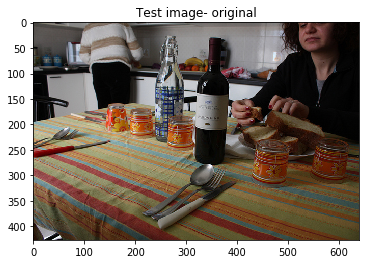

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


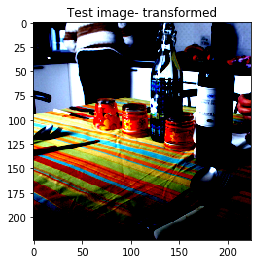

Best model is loaded from ./models/best-model.pkl . . .
Loading vocab from ~/obj/vocab.pkl
example sentence: 

a <UNK> a <UNK> <UNK> a <UNK> <UNK> <UNK> .


In [2]:
from model_utils import predict_any_image

image_folder_path = './data/images/'
model_path = './testmodels/balanced_mode_reg/best-model.pkl'
vocab_path = './testmodels/balanced_mode_reg/vocab.pkl'
#predict_any_image(image_folder_path = image_folder_path, vocab_path = vocab_path, model_path = model_path)
predict_any_image(image_folder_path = image_folder_path)


## Part IV. Evaluate performance of model

You can use the function **get_test_indices** in data_utils to extract 
- random
- balanced_mode: balanced between male, female and neutral gender nouns, using estimated Ground Truth labels
- balanced_clean: balanced between male, female and neutral gender nouns, only using images when all captions agree on the same gender noun

In [20]:
from data_utils import get_test_indices

sample_size = 100
test_indices = get_test_indices(sample_size, training_image_ids, mode = 'balanced_clean')

Loading im_gender_summary from ~/obj/im_gender_summary.pkl
Loading captions_dict from ~/obj/captions_dict.pkl
